In [2]:
%load_ext autoreload
%autoreload 2


In this example we run through a simplified procedure to calculate the inter-molecular electronic coupling energies between penta-3-hexylthiophene

Procedure:
    * Generate models of thiophene and hexane based on based on quantum chemistry data from NWChem
    * Use stream to create a 3-hexylthiophene pentamer
    * Replicate the pentamer into a periodic simulation cell
    * Anneal the system with LAMMPS
    * Calculate the inter-molecular electronic coupling using NWChem's electron transfer module 

In [3]:
import os 
from pprint import pprint

In [4]:
import csv 

In [5]:
import numpy as np
import decimal
import copy

In [6]:
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
%matplotlib inline

In [7]:
import time

Set wait time to check if calculation has finished

In [8]:
status_refresh = 1

In [2]:
import streamm

In this getting started example we will calculate the coupling between P3HT oligomers

In [10]:
import logging
logging.basicConfig(filename='p3ht_et.log',level=logging.DEBUG)

Load Resource objects from Resource example

In [4]:
res_local = streamm.Resource('res_local')
res_calc  = streamm.Resource('res_ssh')

In [5]:
res_local.import_json()

In [6]:
res_calc.import_json()

IOError: [Errno 2] No such file or directory: u'res_ssh_res.json'

In [13]:
res_local.make_dir()

Now we need to set a remote resource we have ssh access to and run calculations 

In [14]:
peregrine = streamm.Resource('peregrine')

In [15]:
peregrine.meta['type'] = "ssh"
peregrine.ssh['username'] = "tkemper"    
peregrine.ssh['address'] = "peregrine.hpc.nrel.gov"    
peregrine.dir['storage'] = '/mss/users/%s'%(peregrine.ssh['username'])
peregrine.dir['scratch'] = '/scratch/%s'%(peregrine.ssh['username'])
peregrine.dir['home'] = res_local.dir['home']
peregrine.dir['launch'] = res_local.dir['launch']
peregrine.dir['templates'] = res_local.dir['templates']

# Set default simulation specs
peregrine.properties['allocation'] = 'orgopv'
peregrine.properties['e-mail'] = 'travis.kemper@nrel.gov'
peregrine.properties['scratch'] = peregrine.dir['scratch']
peregrine.properties['allocation'] = 'orgopv'
peregrine.properties['walltime'] = 4
peregrine.properties['nodes'] = int(1)
peregrine.properties['ppn'] = int(24)
peregrine.properties['nproc'] = peregrine.properties['nodes']*peregrine.properties['ppn']
peregrine.properties['queue'] = 'short'
peregrine.properties['feature'] = '24core'
peregrine.properties['exe_command'] = 'qsub '

In [16]:
pprint(peregrine.properties)

{u'allocation': 'orgopv',
 'e-mail': 'travis.kemper@nrel.gov',
 u'exe_command': 'qsub ',
 u'feature': '24core',
 u'nodes': 1,
 u'nproc': 24,
 u'pmem': 1500,
 u'ppn': 24,
 u'queue': 'short',
 'scratch': '/scratch/tkemper',
 u'walltime': 4}


In [ ]:
peregrine.make_dir()

Now let's create project and resource to keep track of our work

In [ ]:
p3ht_et = streamm.Project('P3HT_ET')

In [ ]:
p3ht_et.set_resource(res_local)

Explicitely create a thiophene molecule

In [ ]:
bbTh = streamm.Buildingblock('thiophene')
symbols = ['C','C','C','C','S','H','H','H','H']
positions = [ ]
positions.append([-1.55498576,-1.91131218,-0.00081000])
positions.append([-0.17775976,-1.91131218,-0.00081000])
positions.append([0.34761524,-0.57904218,-0.00081000])
positions.append([-0.65884476,0.36101082,0.00000000])
positions.append([-2.16948076,-0.35614618,-0.00000800])
positions.append([-2.18966076,-2.79526518,-0.00132100])
positions.append([0.45389024,-2.80145418,-0.00106400])
positions.append([1.41682424,-0.35961818,-0.00138200])
positions.append([-0.51943676,1.44024682,0.00064700])
for i in range(len(symbols)):
    pt_i = streamm.Particle(symbol=symbols[i])
    pos_i = positions[i]
    bbTh.add_partpos(pt_i,pos_i)

In [ ]:
bbTh.particles[5].rsite = 'termcap'
bbTh.particles[6].rsite = 'funccap'
bbTh.particles[8].rsite = 'termcap'

Set some properties of the molecule to keep track of the parts

In [ ]:
c_cnt =1
h_cnt =1

for pkey_i, particle_i  in bbTh.particles.iteritems():

    if( particle_i.symbol == 'C' ):
        particle_i.label = "C%d"%(c_cnt)
        particle_i.resname = "SCP2"
        particle_i.residue = 1

        c_cnt +=1 
    if( particle_i.symbol == 'S' ):
        particle_i.resname = "ThS"
        particle_i.residue = 2

    if( particle_i.symbol == 'H' ):
        particle_i.label = "H%d"%(h_cnt)
        particle_i.resname = "HA"
        particle_i.residue = 3

        h_cnt +=1 


Set the force-field type and guess some reasonable charges 

In [ ]:
for pkey_i, particle_i  in bbTh.particles.iteritems():
    if( particle_i.symbol == 'C' ):
        particle_i.paramkey = 'CA'
        particle_i.charge = -0.025
    if( particle_i.symbol == 'S' ):
        particle_i.paramkey = 'S'
        particle_i.charge = -0.3
    if( particle_i.symbol == 'H' ):
        particle_i.paramkey = 'HA'
        particle_i.charge = 0.1

Check molecule is neutral 

In [ ]:
total_charge = 0.0
for pkey_i, particle_i  in bbTh.particles.iteritems():
    total_charge += particle_i.charge
print total_charge

Optimize structure with NWChem

But let's put it in a function this time

In [ ]:
def nw_opt(project_i,bb_i,res_i):
    '''Optimize a streamm Buildingblock object with nwchem 
    
    '''
    calc_n =  len(project_i.calculations)     
    nwchem_i = streamm.NWChem('nw_opt_{}_calc_{}'.format(bb_i.tag,calc_n))
    print nwchem_i.tag 
    # Add thiophene structure 
    nwchem_i.strucC = copy.deepcopy(bb_i)
    # Set calculation to run on external resource
    nwchem_i.set_resource(res_i)
    # Make the local directories 
    nwchem_i.make_dir()
    #Change to the `launch` directory
    os.chdir(nwchem_i.dir['launch'])
    # Copy over templates
    nwchem_i.cp_file('templates','run',"nwchem_peregrine.pbs",'templates','launch')
    nwchem_i.cp_file('templates','nw',"nwchem.nw",'templates','launch')
    # Read in templates files 
    nwchem_i.load_str('templates','nw')        
    nwchem_i.load_str('templates','run')
    # Set calculation properties 
    nwchem_i.properties['basis'] = '6-31g'
    nwchem_i.properties['method'] = 'UHF'
    nwchem_i.properties['charge'] = 0
    nwchem_i.properties['spin_mult'] = 1
    nwchem_i.properties['task'] = 'SCF optimize'
    nwchem_i.properties['coord'] = nwchem_i.strucC.write_coord()
    # 
    pprint(nwchem_i.properties)
    # Replace <key> with properties value 
    nwchem_i.replacewrite_prop('nw','input','nw','%s.nw'%(nwchem_i.tag))
    nwchem_i.properties['input_nw'] = nwchem_i.files['input']['nw']
    nwchem_i.replacewrite_prop('run','scripts','run','%s.pbs'%(nwchem_i.tag))
    #
    nwchem_i.add_file('output','log',"%s.log"%(nwchem_i.tag))
    # Save details in .json files 
    os.chdir(nwchem_i.dir['home'])
    p3ht_et.export_json()
    # 
    os.chdir(nwchem_i.dir['launch'])
    # 
    nwchem_i.push()
    # 
    nwchem_i.run()
    # Add calculation to project
    project_i.add_calc(nwchem_i,deepcopy = True)
    # 
    return project_i 

In [ ]:
p3ht_et = nw_opt(p3ht_et,bbTh,peregrine)

In [ ]:
nwchem_i = p3ht_et.calculations['nw_opt_thiophene_calc_0']

Check status unit finished

In [ ]:
while( nwchem_i.meta['status'] != 'finished'):
    nwchem_i.check()
    time.sleep(status_refresh)    

In [ ]:
print nwchem_i.meta['status']

In [ ]:
nwchem_i.analysis()

Print energies 

In [ ]:
print nwchem_i.properties['energy'],nwchem_i.unit_conf['energy']

Check that the positions of the structure have been optimized 

In [ ]:
print bbTh.positions

In [ ]:
bbTh.unit_conf['length']

In [ ]:
print nwchem_i.strucC.positions

In [ ]:
nwchem_i.strucC.unit_conf['length']

Update positions with optimized geometry 

In [ ]:
for pk,p in bbTh.particles.iteritems():
    bbTh.positions[pk] = nwchem_i.strucC.positions[pk]
    print pk,p.symbol,bbTh.positions[pk]

Store the results in a tar ball in the storage directory 

In [ ]:
nwchem_i.store()

Now let us calculate the ESP charges to use in our forcefield 

Again let's make it a function

In [ ]:
def nw_esp(project_i,bb_i,res_i):
    '''Calculate ESP charges of a streamm Buildingblock object with nwchem 
    
    '''
    calc_n =  len(project_i.calculations)     
    nwchem_esp = streamm.NWChem('nw_esp_{}_calc_{}'.format(bb_i.tag,calc_n))
    print(nwchem_esp.tag)
    # Add thiophene structure with optimized coordinates from previous calculation
    nwchem_esp.strucC = copy.deepcopy(bb_i)
    # Set calculation to run on external resource
    nwchem_esp.set_resource(res_i)
    # Add calculation to project
    project_i.add_calc(nwchem_esp)
    # Make the local directories 
    nwchem_esp.make_dir()
    # Change to the `launch` directory
    os.chdir(nwchem_esp.dir['launch'])
    #
    nwchem_esp.cp_file('templates','run',"nwchem_peregrine.pbs",'templates','launch')
    nwchem_esp.cp_file('templates','nw',"nwchem_esp.nw",'templates','launch')
    #
    nwchem_esp.load_str('templates','nw')        
    nwchem_esp.load_str('templates','run')
    # 
    nwchem_esp.properties['basis'] = '6-31g'
    nwchem_esp.properties['method'] = 'UHF'
    nwchem_esp.properties['charge'] = 0
    nwchem_esp.properties['spin_mult'] = 1
    nwchem_esp.properties['task'] = 'SCF'
    nwchem_esp.properties['coord'] = nwchem_esp.strucC.write_coord()

    pprint(nwchem_esp.properties)

    nwchem_esp.replacewrite_prop('nw','input','nw','%s.nw'%(nwchem_esp.tag))

    nwchem_esp.properties['input_nw'] = nwchem_esp.files['input']['nw']
    nwchem_esp.replacewrite_prop('run','scripts','run','%s.pbs'%(nwchem_esp.tag))

    nwchem_esp.add_file('output','log',"%s.log"%(nwchem_esp.tag))

    # Save details in .json files 

    os.chdir(nwchem_esp.dir['home'])
    nwchem_esp.export_json()

    os.chdir(nwchem_esp.dir['launch'])
    nwchem_esp.push()
    nwchem_esp.run()
    # Add calculation to project
    project_i.add_calc(nwchem_esp,deepcopy = True)
    # 
    return project_i 
    
    

In [ ]:
p3ht_et = nw_esp(p3ht_et,bbTh,peregrine)

Check status until finished

In [ ]:
nwchem_i = p3ht_et.calculations['nw_esp_thiophene_calc_1']

In [ ]:
while( nwchem_i.meta['status'] != 'finished'):
    nwchem_i.check()
    time.sleep(status_refresh)    

In [ ]:
p3ht_et.check()

In [ ]:
nwchem_i.analysis()

In [ ]:
total_charge = 0.0 
for pk,p in nwchem_i.strucC.particles.iteritems():
    print pk,p.symbol,p.charge
    total_charge += p.charge
print total_charge

Hum a little extra charge can cause problems with our MD simulation so let's round and set to neutral 

In [ ]:
total_charge = 0.0 
for pk,p in nwchem_i.strucC.particles.iteritems():
    p.charge = round(p.charge,4)
    total_charge += p.charge
print total_charge
for pk,p in nwchem_i.strucC.particles.iteritems():
    p.charge += -1.0*total_charge/nwchem_i.strucC.n_particles 
nwchem_i.strucC.calc_charge()
print nwchem_i.strucC.charge



Update the charges of the Buildingblock

In [ ]:
bbTh.tag += '_HFesp'

In [ ]:
for pk,p in bbTh.particles.iteritems():
    p.charge = nwchem_i.strucC.particles[pk].charge
    print pk,p.symbol,p.charge

Store the results 

In [ ]:
nwchem_i.store()

In [ ]:
bbTh.bonded_nblist = bbTh.guess_nblist(0,radii_buffer=1.35)

In [ ]:
bbTh.bonded_bonds()
bbTh.bonded_angles()
bbTh.bonded_dih()

Store a object of the Buildingblock

In [ ]:
os.chdir(res_local.dir['materials']) 
th_json = bbTh.export_json()

Let us optimize the structure with the oplsaa force-field to check the parameters 

In [ ]:
os.chdir(res_local.dir['home']) 

In [ ]:
from pathlib2 import Path

In [ ]:
need_files = ['oplsaa_param.json']
for f in need_files:
    path = Path(f)
    if not path.is_file():
        print("Need to run forcefields.ipynb")
        os.system("jupyter nbconvert --to python  forcefields.ipynb")
        os.system("python forcefields.py")

In [ ]:
oplsaa = streamm.Parameters('oplsaa')

In [ ]:
oplsaa.import_json(read_file=True)

In [ ]:
print oplsaa

In [ ]:
print oplsaa.unit_conf['energy']

We need to add the conjugated carbons, hydrogen and sulfur atom types 

In [ ]:
import streamm.forcefields.particletype as particletype

In [ ]:
import pymatgen_core.core.periodic_table as periodic_table

Set some parameters from J. Am. Chem. Soc., 1996, 118 (45), pp 11225–11236

In [ ]:
CA = particletype.Particletype('CA')
HA = particletype.Particletype('HA')

In [ ]:
CA.update_units(oplsaa.unit_conf)
HA.update_units(oplsaa.unit_conf)

In [ ]:
CA.epsilon = 0.070 # kcal/mol
CA.sigma = 3.55 # Angstroms 

In [ ]:
HA.epsilon = 0.030 # kcal/mol
HA.sigma = 2.42 # Angstroms 

In [ ]:
CA.mass =  periodic_table.Element['C'].atomic_mass.real
HA.mass =  periodic_table.Element['H'].atomic_mass.real

In [ ]:
print CA,HA

In [ ]:
S = particletype.Particletype('S')

In [ ]:
S.update_units(oplsaa.unit_conf)

Set some parameters from J. Am. Chem. Soc., 1996, 118 (45), pp 11225–11236

In [ ]:
S.epsilon = 0.25 # kcal/mol
S.sigma = 3.55 # Angstroms 

In [ ]:
S.mass =  periodic_table.Element['S'].atomic_mass.real

Add to forcefield parameters container

In [ ]:
oplsaa.add_particletype(CA)
oplsaa.add_particletype(HA)
oplsaa.add_particletype(S)

Set the bond stretching parameters 

In [ ]:
import streamm.forcefields.bondtype as bondtype

In [ ]:
bt_i = bondtype.Bondtype('CA','HA',unit_conf=oplsaa.unit_conf)
bt_i.setharmonic(1.080,367.0)
oplsaa.add_bondtype(bt_i)

In [ ]:
bt_i = bondtype.Bondtype('CA','CA',unit_conf=oplsaa.unit_conf)
bt_i.setharmonic(1.400,469.0)
oplsaa.add_bondtype(bt_i)

In [ ]:
bt_i = bondtype.Bondtype('S','CA',unit_conf=oplsaa.unit_conf)
bt_i.setharmonic(1.71,250.0)
oplsaa.add_bondtype(bt_i)

In [ ]:
for btk,bt in oplsaa.bondtypes.iteritems():
    print btk,bt

In [ ]:
import streamm.forcefields.angletype as angletype

In [ ]:
bat_i = angletype.Angletype('CA','CA','CA',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(120.0,63.0)
oplsaa.add_angletype(bat_i)

In [ ]:
bat_i = angletype.Angletype('CA','CA','HA',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(120.0,35.0)
oplsaa.add_angletype(bat_i)

In [ ]:
bat_i = angletype.Angletype('CA','S','CA',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(92.2,70.0)
oplsaa.add_angletype(bat_i)

In [ ]:
bat_i = angletype.Angletype('S','CA','HA',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(120.0,35.0)
oplsaa.add_angletype(bat_i)

In [ ]:
bat_i = angletype.Angletype('S','CA','CA',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(111.0,70.0)
oplsaa.add_angletype(bat_i)

In [ ]:
for atk,at in oplsaa.angletypes.iteritems():
    print atk,at

Set some reasonable dihedral parameters

In [ ]:
import streamm.forcefields.dihtype as dihtype

In [ ]:
dih_i = dihtype.Dihtype('X','CA','CA','X',unit_conf=oplsaa.unit_conf)
dih_i.type ='opls'
dih_i.setopls(0.0,1.812532,0.0,0.0)
oplsaa.add_dihtype(dih_i)

In [ ]:
dih_i = dihtype.Dihtype('X','S','CA','X',unit_conf=oplsaa.unit_conf)
dih_i.type ='opls'
dih_i.setopls(0.0,2.416710,0.0,0.0)
oplsaa.add_dihtype(dih_i)

In [ ]:
dih_i = dihtype.Dihtype('S','CA','CA','HA',unit_conf=oplsaa.unit_conf)
dih_i.type ='opls'
dih_i.setopls(0.0,1.812532,0.0,0.0)
oplsaa.add_dihtype(dih_i)

In [ ]:
for dk,d in oplsaa.dihtypes.iteritems():
    print dk,d 

Let us make an MD simulation of just the monomer to check that our parameters are okay

In [ ]:
def lmp_run(project_i,bb_i,param_i,res_i,md_type = 'min'):
    # Create LAMMPS calculation object 
    calc_n =  len(project_i.calculations)     
    lmp_i = streamm.LAMMPS('lmp_{}_{}_calc_{}'.format(md_type,bb_i.tag,calc_n))
    # lmp_i = streamm.LAMMPS('lmp_{}_{}'.format(md_type,bb_i.tag))
    # Set parameter container 
    lmp_i.paramC = param_i
    lmp_i.set_strucC(bb_i)
    # Set force-field parameters 
    lmp_i.set_ffparam()
    # Set resource to local
    lmp_i.set_resource(res_i)
    # Make local directories
    lmp_i.make_dir()
    # Set pbc's to on
    lmp_i.strucC.lat.pbcs = [True,True,True]
    # Change to launch directory
    os.chdir(lmp_i.dir['launch'])
    # Copy over the templates from the template directory 
    lmp_i.cp_file('templates','in',"lammps_{}.in".format(md_type),'templates','launch')
    lmp_i.cp_file('templates','run',"lammps_peregrine.pbs",'templates','launch')
    # Change to scratch
    os.chdir(lmp_i.dir['launch'])
    # Read in template files and store them as strings in the `str` dictionary
    lmp_i.load_str('templates','in')
    lmp_i.load_str('templates','run')
    # Write LAMMPS .data file
    lmp_i.write_data()
    # Replace keys in template string with properties 
    lmp_i.replacewrite_prop('in','input','in','%s.in'%(lmp_i.tag))
    # Add the input file to the properties to be written into the run file
    lmp_i.properties['input_in'] = lmp_i.files['input']['in']
    lmp_i.replacewrite_prop('run','scripts','run','%s.pbs'%(lmp_i.tag))
    # Save json file in root directory
    os.chdir(lmp_i.dir['home'])
    lmp_i.export_json()
    # Run bash script or submit to cluster
    lmp_i.add_file('output','log',"%s.log"%(lmp_i.tag))
    # Save details in .json files 
    os.chdir(lmp_i.dir['home'])
    lmp_i.export_json()
    #
    os.chdir(lmp_i.dir['launch'])
    lmp_i.push()
    lmp_i.run()
    # Add calculation to project
    project_i.add_calc(lmp_i,deepcopy = True)
    # 
    return project_i     

In [ ]:
print p3ht_et.calculations.keys()

In [ ]:
p3ht_et = lmp_run(p3ht_et,bbTh,oplsaa,peregrine)

In [ ]:
lmp_i = p3ht_et.calculations['lmp_min_thiophene_HFesp_calc_2']

In [ ]:
while( lmp_i.meta['status'] != 'finished'):
    lmp_i.check()
    time.sleep(status_refresh)    

In [ ]:
p3ht_et.check()

In [ ]:
lmp_i.analysis()

Energy decreased and nothing exploded so that's good

In [ ]:
lmp_i.store()

Read in data file positions

In [ ]:
lmp_i.pull()

Read in data file output and update positions

In [ ]:
os.chdir(lmp_i.dir['launch'])

In [ ]:
datafn = lmp_i.files['output']['data_1']
print datafn

In [ ]:
lmp_i.read_data_pos(datafn)

In [ ]:
print lmp_i.strucC.lat.matrix

In [ ]:
lmp_i.strucC.write_xyz()

We will use the oplsaa optimized structure as the initial structure since we will be running MD 

In [ ]:
bbTh.tag += '_oplsaa'

In [ ]:
for pk,p in bbTh.particles.iteritems():
    bbTh.positions[pk] = lmp_i.strucC.positions[pk]
    print pk,p.symbol,bbTh.positions[pk]

Save the Buildingblock and force-field

In [ ]:
os.chdir(res_local.dir['materials']) 
bbTh.write_xyz()
th_json = bbTh.export_json() 
oplsaa_json = oplsaa.export_json()

Okay now that we have a handle on thiophene let's follow the same procedure for hexane

Build hexane

In [ ]:
bbHex = streamm.Buildingblock('hexane')
symbols = ['C','H','H','H','C','H','H','C','H','H','C','H','H','C','H','H','C','H','H','H']
positions = [ ]
positions.append([-6.410969,-0.381641,-0.000031])
positions.append([-7.310084,0.245311,-0.000038])
positions.append([-6.456117,-1.028799,0.884636])
positions.append([-6.456111,-1.028812,-0.884689])
positions.append([-5.135268,0.467175,-0.000033])
positions.append([-5.135484,1.128782,0.877977])
positions.append([-5.135479,1.128771,-0.87805])
positions.append([-3.850566,-0.371258,-0.000024])
positions.append([-3.85112,-1.033978,0.87841])
positions.append([-3.851114,-1.033987,-0.878451])
positions.append([-2.567451,0.469603,-0.000024])
positions.append([-2.567784,1.132155,0.8784])
positions.append([-2.567776,1.132146,-0.878455])
positions.append([-1.283527,-0.370234,-0.000013])
positions.append([-1.28337,-1.032804,0.87836])
positions.append([-1.28336,-1.032812,-0.87838])
positions.append([0.00482234,0.47342231,-0.00000898])
positions.append([0.02595107,1.09220686,0.87266464])
positions.append([0.85585781,-0.17514133,0.00194589])
positions.append([0.02780957,1.08937798,-0.87463473])
for i in range(len(symbols)):
    pt_i = streamm.Particle(symbol=symbols[i])
    pos_i = positions[i]
    bbHex.add_partpos(pt_i,pos_i)

In [ ]:
bbHex.particles[0].rsite = 'rg'
bbHex.particles[1].rsite = 'rgcap'

In [ ]:
c_cnt =1
h_cnt =1
for pkey_i, particle_i  in bbHex.particles.iteritems():
            if( particle_i.symbol == 'C' ):
                particle_i.label = "C%d"%(c_cnt)
                particle_i.resname = "SCP3"
                particle_i.residue = c_cnt
                c_cnt +=1 
            if( particle_i.symbol == 'H' ):
                particle_i.label = "H%d"%(h_cnt)
                particle_i.resname = "HC"
                particle_i.residue = c_cnt -1 
                h_cnt +=1 

Set the parameter keys and some reasonable atomic charges 

In [ ]:
for pkey_i, particle_i  in bbHex.particles.iteritems():
            if( particle_i.symbol == 'C' ):
                particle_i.paramkey = 'CT'
                particle_i.charge = -0.12

            if( particle_i.symbol == 'H' ):
                particle_i.paramkey = 'HC'
                particle_i.charge = 0.06
            print pkey_i, particle_i.symbol,particle_i.charge

In [ ]:
bbHex.particles[0].charge  = -0.18
bbHex.particles[16].charge  = -0.18

Check that the molecule is neutral 

In [ ]:
bbHex.calc_charge()
print bbHex.charge


Now let us optimze and calculate ESP charges for hexane

Optimize structure with NWChem

In [ ]:
print p3ht_et.calculations.keys()

In [ ]:
p3ht_et = nw_opt(p3ht_et,bbHex,peregrine)

In [ ]:
nwchem_i = p3ht_et.calculations['nw_opt_hexane_calc_3']

In [ ]:
p3ht_et.check()

In [ ]:
while( nwchem_i.meta['status'] != 'finished'):
    nwchem_i.check()
    time.sleep(status_refresh)

Get the calculation from the project object 

In [ ]:
nwchem_i.analysis()

Print energies 

In [ ]:
print nwchem_i.properties['alpha_energies'][10:20]
print nwchem_i.properties['energy']

Check that the positions of the structure have been optimized 

In [ ]:
for pk,p in bbHex.particles.iteritems():
    print pk,p.symbol,bbHex.positions[pk]

In [ ]:
print nwchem_i.strucC.positions

Update positions in Buildingblock object

In [ ]:
for pk,p in bbHex.particles.iteritems():
    bbHex.positions[pk] = nwchem_i.strucC.positions[pk]
    print pk,p.symbol,bbHex.positions[pk]

Store the results in a tar ball in the storage directory 

In [ ]:
nwchem_i.store()

Now let us calculate the ESP charges to use in our forcefield 

In [ ]:
p3ht_et = nw_esp(p3ht_et,bbHex,peregrine)

Check status unit finished

In [ ]:
p3ht_et.check()

In [ ]:
nwchem_i = p3ht_et.calculations['nw_esp_hexane_calc_4']

In [ ]:
while( nwchem_i.meta['status'] != 'finished'):
    nwchem_i.check()
    time.sleep(status_refresh)

In [ ]:
nwchem_i.analysis()

In [ ]:
for pk,p in nwchem_i.strucC.particles.iteritems():
    print pk,p.symbol,p.charge

In [ ]:
nwchem_i.strucC.calc_charge()
print nwchem_i.strucC.charge

Hum a little extra charge can cause problems with our MD simulation so let's round and set to neutral 

In [ ]:
total_charge = 0.0 
for pk,p in nwchem_i.strucC.particles.iteritems():
    p.charge = round(p.charge,4)
    total_charge += p.charge
print total_charge
for pk,p in nwchem_i.strucC.particles.iteritems():
    p.charge += -1.0*total_charge/nwchem_i.strucC.n_particles 
nwchem_i.strucC.calc_charge()
print nwchem_i.strucC.charge



Print energies 

In [ ]:
print nwchem_i.properties['energy'],nwchem_i.unit_conf['energy']

Update the charges of the Buildingblock

In [ ]:
for pk,p in bbHex.particles.iteritems():
    p.charge = nwchem_i.strucC.particles[pk].charge

In [ ]:
bbHex.tag += '_HFesp'

Store the results 

In [ ]:
nwchem_i.store()

First we need to identify the bonding within the Buildingblock

In [ ]:
bbHex.bonded_nblist = bbHex.guess_nblist(0,radii_buffer=1.35)

In [ ]:
bbHex.bonded_bonds()
bbHex.bonded_angles()
bbHex.bonded_dih()

Add the need parameters the the oplsaa parameter container

In [ ]:
bat_i = angletype.Angletype('CT','CT','CT',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(109.50,40.0)
oplsaa.add_angletype(bat_i)

In [ ]:
bat_i = angletype.Angletype('CT','CT','CT',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(109.50,40.0)
oplsaa.add_angletype(bat_i)

In [ ]:
bat_i = angletype.Angletype('CT','CT','HC',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(109.50,50.0)
oplsaa.add_angletype(bat_i)

In [ ]:
dih_i = dihtype.Dihtype('CT','CT','CT','CT',unit_conf=oplsaa.unit_conf)
dih_i.type ='opls'
dih_i.setopls(0.433341,-0.016667,0.066668,0.0)
oplsaa.add_dihtype(dih_i)

In [ ]:
dih_i = dihtype.Dihtype('HC','CT','CT','CT',unit_conf=oplsaa.unit_conf)
dih_i.type ='opls'
dih_i.setopls(0.0,-0.0,0.1,0.0)
oplsaa.add_dihtype(dih_i)

In [ ]:
dih_i = dihtype.Dihtype('HC','CT','CT','HC',unit_conf=oplsaa.unit_conf)
dih_i.type ='opls'
dih_i.setopls(0.0,-0.0,0.1,0.0)
oplsaa.add_dihtype(dih_i)

Run a oplsaa minimization to get the minimized structure

In [ ]:
p3ht_et = lmp_run(p3ht_et,bbHex,oplsaa,peregrine)

In [ ]:
p3ht_et.check()

In [ ]:
lmp_i = p3ht_et.calculations['lmp_min_hexane_HFesp_calc_5']

In [ ]:
while( lmp_i.meta['status'] != 'finished'):
    lmp_i.check()
    time.sleep(status_refresh)

In [ ]:
lmp_i.analysis()

Energy decreased and nothing exploded so that's good

In [ ]:
lmp_i.store()

Read in data file positions

In [ ]:
lmp_i.pull()

Read in data file output and update positions

In [ ]:
print lmp_i.dir['launch']
os.chdir(lmp_i.dir['launch'])

In [ ]:
datafn = lmp_i.files['output']['data_1']
print datafn

In [ ]:
lmp_i.read_data_pos(datafn)

In [ ]:
print lmp_i.strucC.lat.matrix

In [ ]:
lmp_i.strucC.write_xyz()

We will use the oplsaa optimized structure as the initial structure since we will be running MD 

In [ ]:
bbHex.tag += '_oplsaa'

In [ ]:
for pk,p in bbHex.particles.iteritems():
    bbHex.positions[pk] = lmp_i.strucC.positions[pk]
    print pk,p.symbol,bbHex.positions[pk]

Save the Buildingblock and force-field

In [ ]:
os.chdir(res_local.dir['materials']) 
bbHex.write_xyz()
bbhex_json = bbHex.export_json() 
oplsaa_json = oplsaa.export_json()

In [ ]:
print bbHex.tag,bbTh.tag

So let us make some P3HT oligomers 

In [ ]:
os.chdir(res_local.dir['materials']) 

In [ ]:
bbTh.find_rsites()
bbHex.find_rsites()

In [ ]:
print(bbTh.show_rsites())

In [ ]:
print(bbHex.show_rsites())

In [ ]:
import streamm.structures.buildingblock as bb

In [ ]:
ht = bb.attach(bbTh,bbHex,'funccap',0,'rgcap',0,tag='3-hexyl-thiophene')

Update bond angles and dihedrals after Buildingblock join

In [ ]:
ht.bonded_bonds()
ht.bonded_angles()
ht.bonded_dih()

Check that the molecule looks good

In [ ]:
ht.write_xyz()

Check the charges of the removed hydrogens got summed onto the functionalized carbons correctly

In [ ]:
ht.calc_charge()
ht.charge

In [ ]:
print(ht.show_rsites())

Add inter thiophene hexane parameters

In [ ]:
bt_i = bondtype.Bondtype('CT','CA',unit_conf=oplsaa.unit_conf)
bt_i.setharmonic(1.51,317.0)
oplsaa.add_bondtype(bt_i)

Bond angle parameters 

In [ ]:
bat_i = angletype.Angletype('CA','CA','CT',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(120.0,70.0)
oplsaa.add_angletype(bat_i)


bat_i = angletype.Angletype('HA','CA','CT',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(120.0,35.0)
oplsaa.add_angletype(bat_i)



bat_i = angletype.Angletype('CA','CT','HC',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(109.5,50.0)
oplsaa.add_angletype(bat_i)

bat_i = angletype.Angletype('CA','CT','CT',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(114.0,63.0)
oplsaa.add_angletype(bat_i)

In [ ]:
for atk,at in oplsaa.angletypes.iteritems():
    print atk,at

Note: The inter-ring torsional is not consider as a seperate set of parameters for the simplicity of this example

In [ ]:
dih_i = dihtype.Dihtype('HC','CT','CT','CA',unit_conf=oplsaa.unit_conf)
dih_i.type ='opls'
dih_i.setopls(0.0,-0.0,0.1,0.0)
oplsaa.add_dihtype(dih_i)

In [ ]:
dih_i = dihtype.Dihtype('CT','CT','CT','CA',unit_conf=oplsaa.unit_conf)
dih_i.type ='opls'
dih_i.setopls(0.433341,-0.016667,0.066668,0.0)
oplsaa.add_dihtype(dih_i)

In [ ]:
dih_i = dihtype.Dihtype('HC','CT','CA','CA',unit_conf=oplsaa.unit_conf)
dih_i.type ='opls'
dih_i.setopls(0.0,-0.0,0.1,0.0)
oplsaa.add_dihtype(dih_i)

In [ ]:
dih_i = dihtype.Dihtype('CT','CT','CA','CA',unit_conf=oplsaa.unit_conf)
dih_i.type ='opls'
dih_i.setopls(0.0,-0.0,0.0,0.0)
oplsaa.add_dihtype(dih_i)

In [ ]:
for dk,d in oplsaa.dihtypes.iteritems():
    print dk,d 

Run a oplsaa minimization to get the minimized structure

In [ ]:
p3ht_et = lmp_run(p3ht_et,ht,oplsaa,peregrine)

In [ ]:
p3ht_et.check()

In [ ]:
lmp_i = p3ht_et.calculations['lmp_min_3-hexyl-thiophene_calc_6']

In [ ]:
while( lmp_i.meta['status'] != 'finished'):
    lmp_i.check()
    time.sleep(status_refresh)

In [ ]:
lmp_i.analysis()

Energy decreased and nothing exploded so that's good

In [ ]:
lmp_i.store()

Read in data file positions

In [ ]:
lmp_i.pull()

Read in data file output and update positions

In [ ]:
print lmp_i.dir['launch']
os.chdir(lmp_i.dir['launch'])

In [ ]:
datafn = lmp_i.files['output']['data_1']
print datafn

In [ ]:
lmp_i.read_data_pos(datafn)

In [ ]:
print lmp_i.strucC.lat.matrix

We will use the oplsaa optimized structure as the initial structure since we will be running MD 

In [ ]:
ht.tag += '_oplsaa'

In [ ]:
for pk,p in ht.particles.iteritems():
    ht.positions[pk] = lmp_i.strucC.positions[pk]
    print pk,p.symbol,ht.positions[pk]

Save the Buildingblock and force-field

In [ ]:
os.chdir(res_local.dir['materials']) 
ht.write_xyz()
ht_json = ht.export_json() 
ht_json = oplsaa.export_json()

Okay we have the monomer, so let's make a pentamer 

In [ ]:
penta_ht = copy.deepcopy(ht)

In [ ]:
# We could use prepattach to change the tacticity 
# penta_ht = ht.prepattach('termcap',0,dir=-1,yangle=180.0)
# See buildingblock example 

In [ ]:
for n in range(4):
    penta_ht = bb.attach(penta_ht,ht,'termcap',1,'termcap',0,tag='penta_3-hexyl-thiophene')

Check the charges of the removed hydrogens got summed onto the functionalized carbons correctly

In [ ]:
penta_ht.calc_charge()
penta_ht.charge

In [ ]:
penta_ht.write_xyz()

Well it's cis, but we can run some high temperature MD to randomize that 

Update bond angles and dihedrals after Buildingblock join

In [ ]:
penta_ht.bonded_bonds()
penta_ht.bonded_angles()
penta_ht.bonded_dih()

In [ ]:
print penta_ht.print_properties()

Run a oplsaa minimization to get the minimized structure

In [ ]:
p3ht_et = lmp_run(p3ht_et,penta_ht,oplsaa,peregrine)

In [ ]:
p3ht_et.check()

In [ ]:
lmp_i = p3ht_et.calculations['lmp_min_penta_3-hexyl-thiophene_calc_7']

In [ ]:
while( lmp_i.meta['status'] != 'finished'):
    lmp_i.check()
    time.sleep(status_refresh)

In [ ]:
lmp_i.analysis()

Energy decreased and nothing exploded so that's good

In [ ]:
lmp_i.store()

Read in data file positions

In [ ]:
lmp_i.pull()

Read in data file output and update positions

In [ ]:
print lmp_i.dir['launch']
os.chdir(lmp_i.dir['launch'])

In [ ]:
datafn = lmp_i.files['output']['data_1']
print datafn

In [ ]:
lmp_i.read_data_pos(datafn)

In [ ]:
print lmp_i.strucC.lat.matrix

In [ ]:
lmp_i.strucC.write_xyz()

We will use the oplsaa optimized structure as the initial structure since we will be running MD 

In [ ]:
penta_ht.tag += '_oplsaa'

In [ ]:
for pk,p in penta_ht.particles.iteritems():
    penta_ht.positions[pk] = lmp_i.strucC.positions[pk]
    print pk,p.symbol,penta_ht.positions[pk]

Save the Buildingblock and force-field

In [ ]:
oplsaa.tag += '_p3ht'

In [ ]:
os.chdir(res_local.dir['materials']) 
penta_ht.write_xyz()
penta_ht_json = penta_ht.export_json() 
oplsaa_json = oplsaa.export_json()

Cool let's run some MD

In [ ]:
p3ht_et = lmp_run(p3ht_et,penta_ht,oplsaa,peregrine,md_type='nvt')

In [ ]:
p3ht_et.check()

In [ ]:
lmp_i = p3ht_et.calculations['lmp_nvt_penta_3-hexyl-thiophene_oplsaa_calc_8']

In [ ]:
while( lmp_i.meta['status'] != 'finished'):
    lmp_i.check()
    time.sleep(status_refresh)

In [ ]:
lmp_i.analysis()

In [ ]:
lmp_i.store()

Read in data file positions

In [ ]:
lmp_i.pull()

Read in data file output and update positions

In [ ]:
os.chdir(lmp_i.dir['launch'])

In [ ]:
datafn = lmp_i.files['output']['data_3']
print datafn

In [ ]:
lmp_i.read_data_pos(datafn)

In [ ]:
print lmp_i.strucC.lat.matrix

In [ ]:
lmp_i.strucC.write_xyz()

Awesome! We have a randomized pentamer, so let's save that as new Buildingblock

In [ ]:
bbPHTh_1 = copy.deepcopy(lmp_i.strucC)

In [ ]:
print bbPHTh_1

In [ ]:
print bbPHTh_1.n_particles

In [ ]:
os.chdir(res_local.dir['materials']) 
bbPHTh_1.write_xyz()
bbPHTh_1_json = bbPHTh_1.export_json() 

Now let's replicate the oligomer 50 times to create a low density system

Increase the box size

In [ ]:
pHTh_x = streamm.Buildingblock()

In [ ]:
pHTh_x.lat.matrix = [ 200.,0.,0., 0.,200.,0.,  0.,0.,200.]

In [ ]:
pHTh_x.lat.pbcs = [False,False,False]

In [ ]:
seed = 394572

Randomly place oligomers into the simulation cell

In [ ]:
pHTh_x = streamm.add_struc(pHTh_x,bbPHTh_1,50,seed)

In [ ]:
print pHTh_x.n_particles
print pHTh_x.lat.matrix

In [ ]:
pHTh_x.lat.pbcs = [True,True,True]

Check grouping 

In [ ]:
groupset_i = streamm.Groups('mol',pHTh_x)
groupset_i.group_prop('mol','oligomers')

In [ ]:
print len(groupset_i.groups)

In [ ]:
groupset_i.strucC.lat.pbcs

In [ ]:
pHTh_x.tag = 'p3HTx50'

In [ ]:
os.chdir(res_local.dir['materials']) 
pHTh_x.write_xyz()
pHTh_json = pHTh_x.export_json() 

Run a heat cool cycle with NPT to create a solid phase representation of p3HT

In [ ]:
p3ht_et = lmp_run(p3ht_et,pHTh_x,oplsaa,peregrine,md_type = 'equ0')

In [ ]:
p3ht_et.check()

In [ ]:
lmp_i = p3ht_et.calculations['lmp_equ0_p3HTx50_calc_9']

In [ ]:
print lmp_i.tag

In [ ]:
while( lmp_i.meta['status'] != 'finished'):
    lmp_i.check()
    time.sleep(status_refresh)

In [ ]:
lmp_i.analysis()

In [ ]:
print lmp_i.properties['run_cnt']

In [ ]:
run_i = lmp_i.run_list[0]

Plot the time sereies data from the MD runs 

In [ ]:
def plot_mdrun(lmp_i):


    fig, ax = plt.subplots(1,sharey=True)
    ax2 = ax.twinx()

    for run_i in lmp_i.run_list:

        ax.plot(run_i.timeseries['step'],run_i.timeseries['volume'],'b.-')

        ax2.plot(run_i.timeseries['step'],run_i.timeseries['temp'],'k.-')

    ax.set_ylabel('volume', color='b')
    ax2.set_ylabel('temp', color='k')
    ax.set_xlabel('time (fs)', color='k')


    fig.subplots_adjust(hspace=0.0)   
    fig.set_size_inches(8.0, 12.0)

    fig.savefig('{}.pdf'.format(lmp_i.tag),format='pdf')



In [ ]:
plot_mdrun(lmp_i)

Cool the volume is decreasing 

In [ ]:
lmp_i.store()

In [ ]:
lmp_i.pull()

Read in data file output and update positions

In [ ]:
os.chdir(lmp_i.dir['launch'])

In [ ]:
datafn = lmp_i.files['output']['data_3']
print datafn

In [ ]:
lmp_i.read_data_pos(datafn)

In [ ]:
print lmp_i.strucC.lat.matrix

In [ ]:
lmp_i.strucC.tag += '_equ0'

In [ ]:
lmp_i.strucC.write_xyz()

In [ ]:
lmp_i.strucC.calc_center_mass()

In [ ]:
struc_i = lmp_i.strucC

In [ ]:
struc_json = struc_i.export_json()

Let us create a new project to hold all the ET calculations we need to do for each pair of groups

In [17]:
mol_et_equ0 = streamm.Project('mol_et_equ0')

In [18]:
mol_et_equ0.set_resource(res_local)

In [20]:
os.chdir(mol_et_equ0.dir['materials'])

If we need to restart the project here all we have to do is load in the structure 

In [24]:
try:
    print  struc_i
except:
    struc_i = streamm.Buildingblock('p3HTx50_equ0')
    struc_i.import_json()

In [ ]:
struc_i.write_xyz('t1.xyz')

Create groups out of the molecules

In [34]:
groupset_i = streamm.Groups('mol',struc_i)

In [35]:
groupset_i.group_prop('mol','oligomers')

In [36]:
print len(groupset_i.groups)

50


In [37]:
groupset_i.strucC.lat.pbcs = [True,True,True]

In [38]:
print groupset_i.strucC.lat.pbcs

[True, True, True]


In [39]:
print groupset_i.strucC.lat.matrix

[[ 62.34228115   0.           0.        ]
 [  0.          62.34228115   0.        ]
 [  0.           0.          62.34228115]]


Apply periodic boundries to all the groups, so the molecules are not split across pbc's

In [40]:
groupset_i.group_pbcs()

In [41]:
groupset_i.strucC.write_xyz('groups.xyz')

In [42]:
groupset_i.calc_cent_mass()
groupset_i.calc_radius()
# groupset_i.calc_dl()

In [43]:
print groupset_i.strucC.lat
print len(groupset_i.cent_mass)
print len(groupset_i.radius)

62.342281 0.000000 0.000000
0.000000 62.342281 0.000000
0.000000 0.000000 62.342281
50
50


Save the structure we are creating our pairs from 

In [44]:
gmol_json = groupset_i.strucC.export_json()

Create a neighbor list of groups 

In [45]:
groupset_i.group_nblist.radii_nblist(groupset_i.strucC.lat,groupset_i.cent_mass,groupset_i.radius,radii_buffer=0.500)

In [46]:
print groupset_i.group_nblist

 NBlist of 50 particle with 142 connections


In [47]:
g_nbs = []
for gk_i,g_i in groupset_i.groups.iteritems():
        n_nbs = groupset_i.group_nblist.calc_nnab(gk_i)
        g_nbs.append(n_nbs)
g_nbs = np.array(g_nbs)    

In [48]:
print g_nbs.min(),g_nbs.mean(),g_nbs.max()

0 2.84 6


Loop over each group, shift the group to the center of the simulation cell and write an .xyz file that includes the neighbors of the group.

In [49]:
for gk_i,g_i in groupset_i.groups.iteritems():
        list_i = copy.deepcopy(g_i.pkeys)
        for g_j in groupset_i.group_nblist.getnbs(gk_i):
            list_i += groupset_i.groups[g_j].pkeys
        print gk_i,groupset_i.group_nblist.calc_nnab(gk_i),len(list_i)
        groupset_i.strucC.shift_pos(-1.0*g_i.cent_mass)  # Place center of mass at origin
        groupset_i.strucC.write_xyz_list(list_i,xyz_file='nn_{}.xyz'.format(gk_i))
        groupset_i.strucC.shift_pos(g_i.cent_mass)  # Return center of mass 
        
        list_i = []
        

0 6 889
1 5 762
2 3 508
3 2 381
4 2 381
5 4 635
6 2 381
7 3 508
8 2 381
9 2 381
10 4 635
11 1 254
12 4 635
13 1 254
14 6 889
15 4 635
16 2 381
17 3 508
18 2 381
19 2 381
20 1 254
21 0 127
22 3 508
23 3 508
24 4 635
25 1 254
26 3 508
27 0 127
28 2 381
29 3 508
30 1 254
31 1 254
32 3 508
33 2 381
34 4 635
35 2 381
36 5 762
37 3 508
38 3 508
39 2 381
40 3 508
41 2 381
42 2 381
43 4 635
44 5 762
45 4 635
46 5 762
47 3 508
48 3 508
49 5 762


The nearest neighbor cluster look good so let us calculate the electron transfer 

Firts create a list of unique pairs 

In [89]:
et_pairs = {}
et_pairs['i'] = []
et_pairs['j'] = []
for gk_i,g_i in groupset_i.groups.iteritems():
    for gk_j in groupset_i.group_nblist.getnbs(gk_i):
        if( gk_j > gk_i ):
            et_pairs['i'].append(gk_i)
            et_pairs['j'].append(gk_j)
            
            

In [ ]:

            
            et_pairs['S_ij'].append(None)
            et_pairs['S_ji'].append(None)
            et_pairs['V_ij'].append(None)
            et_pairs['V_ij'].append(None)



Convert the dictionary to a pandas Dataframe

In [87]:
import pandas as pd

In [90]:
et_df = pd.DataFrame(et_pairs)

In [99]:
et_df.columns

Index([u'i', u'j'], dtype='object')

Save that in a local file 

In [100]:
et_df.to_csv('et_pairs.csv',sep=',')

In [104]:
et_fn = 'et_pairs.csv'
try:
    print  len(et_df)
except:
    et_df = pd.read_csv(et_fn)

71


In [53]:
def nw_et(project_i,res_i,groupset_i,gk_i,gk_j,run_calc = False):

    calc_n =  len(project_i.calculations)     
    nwchem_et = streamm.NWChem('nw_et_{}_g{}_g{}'.format(project_i.tag,gk_i,gk_j))
    print(nwchem_et.tag)

    # Set calculation to run on external resource
    nwchem_et.set_resource(res_i)

    # Make the local directories 
    nwchem_et.make_dir()
    # Change to the `launch` directory
    os.chdir(nwchem_et.dir['launch'])

    group_i = groupset_i.groups[gk_i]
    group_j = groupset_i.groups[gk_j]    

    nwchem_et.properties['coord_i'] = group_i.write_coord()
    nwchem_et.properties['coord_j'] = group_j.write_coord()    
    nwchem_et.properties['coord_ij'] = nwchem_et.properties['coord_i'] + nwchem_et.properties['coord_j'] 
    
    

    nwchem_et.cp_file('templates','run',"nwchem_peregrine.pbs",'templates','launch')
    nwchem_et.cp_file('templates','nw',"nwchem_et.nw",'templates','launch')
    #
    nwchem_et.load_str('templates','nw')        
    nwchem_et.load_str('templates','run')
    # 
    nwchem_et.replacewrite_prop('nw','input','nw','%s.nw'%(nwchem_et.tag))

    nwchem_et.properties['input_nw'] = nwchem_et.files['input']['nw']
    nwchem_et.replacewrite_prop('run','scripts','run','%s.pbs'%(nwchem_et.tag))

    nwchem_et.add_file('output','log',"%s.log"%(nwchem_et.tag))
    # Save details in .json files 
    # 
    os.chdir(nwchem_et.dir['home'])
    nwchem_et.export_json()
    # 
    #
    if( run_calc ):
        os.chdir(nwchem_et.dir['launch'])
        nwchem_et.push()
        nwchem_et.run()
        
    return nwchem_et


Loop over all the pairs and create NWChem ET input files

In [129]:
et_df['calc_id'] = None

In [134]:
for k,pair_i in et_df.iterrows():
    gk_i = pair_i['i']
    gk_j = pair_i['j']
    #nwchem_et = nw_et(mol_et_equ0,peregrine,groupset_i,gk_i,gk_j)
    #et_df['calc_id'] = nwchem_et.tag 
    et_df.loc[k,'calc_id'] = 'nw_et_{}_g{}_g{}'.format(mol_et_equ0.tag,gk_i,gk_j)
    ## Add calculation to project
    # mol_et_equ0.add_calc(nwchem_et,deepcopy = True)    

In [135]:
et_df.head()

,i,j,calc_id
0,0,3,nw_et_mol_et_equ0_g0_g3
1,0,14,nw_et_mol_et_equ0_g0_g14
2,0,15,nw_et_mol_et_equ0_g0_g15
3,0,19,nw_et_mol_et_equ0_g0_g19
4,0,43,nw_et_mol_et_equ0_g0_g43


In [57]:
os.chdir(mol_et_equ0.dir['home'])
et_json = mol_et_equ0.export_json()

Now we have to wait for all of these calculations to finish

In [ ]:
calcsrunning = True 
while( calcsrunning ):
    calcsrunning = False 
    n_running = 0 
    for k,calc_i in mol_et_equ0.calculations.iteritems():
        calc_i.check()
        if( calc_i.meta['status'] != 'finished' ):
            calcsrunning = True 
            n_running += 1
    print("{}/{}".format(n_running,len(mol_et_equ0.calculations)))


Run analysis on the results 

In [186]:
et_df['S_ij'] = None
et_df['S_ji'] = None
et_df['V_ij'] = None
et_df['V_ji'] = None

In [187]:
for k,calc_i in mol_et_equ0.calculations.iteritems():
    calc_i.meta['status'] = 'written'


In [188]:
for k,calc_i in mol_et_equ0.calculations.iteritems():
    calc_i.check()
    if(  calc_i.meta['status'] == 'finished' ):

        print calc_i.tag,calc_i.meta['status'] 
        os.chdir(calc_i.dir['launch'])

        et_row = et_df.loc[ et_df['calc_id'] == calc_i.tag ]
        et_index =  int(et_row.index[0])

        calc_i.analysis()

        if( len(calc_i.et_list) > 0  ):
            et_df.loc[et_index,'S_ij'] = calc_i.et_list[0].S
            et_df.loc[et_index,'V_ij'] = calc_i.et_list[0].V
            et_df.loc[et_index,'S_ji'] = calc_i.et_list[1].S
            et_df.loc[et_index,'V_ji'] = calc_i.et_list[1].V


        calc_i.store()


nw_et_mol_et_equ0_g14_g45 finished
Running analysis on  nw_et_mol_et_equ0_g14_g45.log
nw_et_mol_et_equ0_g10_g49 finished
Running analysis on  nw_et_mol_et_equ0_g10_g49.log
nw_et_mol_et_equ0_g12_g18 finished
Running analysis on  nw_et_mol_et_equ0_g12_g18.log
nw_et_mol_et_equ0_g1_g44 finished
Running analysis on  nw_et_mol_et_equ0_g1_g44.log
nw_et_mol_et_equ0_g8_g38 finished
Running analysis on  nw_et_mol_et_equ0_g8_g38.log
nw_et_mol_et_equ0_g9_g23 finished
Running analysis on  nw_et_mol_et_equ0_g9_g23.log
nw_et_mol_et_equ0_g0_g15 finished
Running analysis on  nw_et_mol_et_equ0_g0_g15.log
nw_et_mol_et_equ0_g0_g14 finished
Running analysis on  nw_et_mol_et_equ0_g0_g14.log
nw_et_mol_et_equ0_g0_g19 finished
Running analysis on  nw_et_mol_et_equ0_g0_g19.log
nw_et_mol_et_equ0_g14_g49 finished
Running analysis on  nw_et_mol_et_equ0_g14_g49.log
nw_et_mol_et_equ0_g20_g40 finished
Running analysis on  nw_et_mol_et_equ0_g20_g40.log
nw_et_mol_et_equ0_g0_g49 finished
Running analysis on  nw_et_mol_e

In [190]:
et_df

,i,j,calc_id,S_ij,S_ji,V_ij,V_ji
0,0,3,nw_et_mol_et_equ0_g0_g3,4.73e-06,4.73e-06,1.396e-07,1.396e-07
1,0,14,nw_et_mol_et_equ0_g0_g14,0,1.05e-19,NaN,0
2,0,15,nw_et_mol_et_equ0_g0_g15,-8.07e-06,-8.07e-06,4.211e-06,4.211e-06
3,0,19,nw_et_mol_et_equ0_g0_g19,-3.32e-05,-3.32e-05,1.65649e-05,1.65649e-05
4,0,43,nw_et_mol_et_equ0_g0_g43,0,4.74e-19,inf,0.0285685
5,0,49,nw_et_mol_et_equ0_g0_g49,0,1.13e-18,NaN,0.0240705
6,1,16,nw_et_mol_et_equ0_g1_g16,-0.000259,-0.000259,0.000202278,0.000202278
7,1,17,nw_et_mol_et_equ0_g1_g17,0,-4.26e-19,inf,0
8,1,28,nw_et_mol_et_equ0_g1_g28,0,-9e-20,inf,0.301077
9,1,33,nw_et_mol_et_equ0_g1_g33,0,6.98e-21,NaN,3.88051


In [191]:
et_c1 = et_df.replace([np.inf], np.nan)

In [192]:
et_c1.dropna()

,i,j,calc_id,S_ij,S_ji,V_ij,V_ji
0,0,3,nw_et_mol_et_equ0_g0_g3,4.730000e-06,4.730000e-06,1.396000e-07,1.396000e-07
2,0,15,nw_et_mol_et_equ0_g0_g15,-8.070000e-06,-8.070000e-06,4.211000e-06,4.211000e-06
3,0,19,nw_et_mol_et_equ0_g0_g19,-3.320000e-05,-3.320000e-05,1.656490e-05,1.656490e-05
6,1,16,nw_et_mol_et_equ0_g1_g16,-2.590000e-04,-2.590000e-04,2.022779e-04,2.022779e-04
10,1,44,nw_et_mol_et_equ0_g1_g44,-4.640000e-07,-4.640000e-07,2.598000e-07,2.598000e-07
11,2,31,nw_et_mol_et_equ0_g2_g31,4.430000e-05,4.430000e-05,9.710200e-06,9.710200e-06
12,2,32,nw_et_mol_et_equ0_g2_g32,-2.390000e-05,-2.390000e-05,1.554690e-05,1.554690e-05
13,2,47,nw_et_mol_et_equ0_g2_g47,9.570000e-05,9.570000e-05,4.788100e-05,4.788100e-05
15,4,12,nw_et_mol_et_equ0_g4_g12,-4.790000e-05,-4.790000e-05,3.431490e-05,3.431490e-05
16,4,39,nw_et_mol_et_equ0_g4_g39,2.290000e-04,2.290000e-04,1.302599e-04,1.302599e-04


In [199]:
print et_c1['V_ij'].min(),et_c1['V_ij'].mean(),et_c1['V_ij'].max()

1.396e-07 0.000104490976087 0.0010632199


We can take a look at the histogram of magnitudes of V_ij

In [204]:
et_c1['log_V_ij'] = np.log10(et_c1['V_ij'])

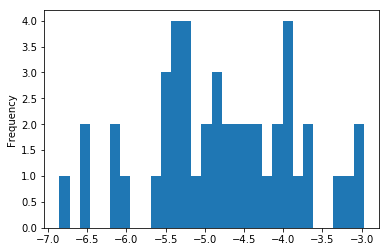

In [211]:
et_c1['log_V_ij'].plot.hist(bins=30,alpha=1.0)

Just calculated the inter-molecular electronic coupling between P3ht

Boom!